In [10]:
from gym.wrappers import FrameStack, RescaleAction, TimeLimit
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from environments import ARESEASequential, ResetActuators

In [2]:
def round_to_multiple(x, k):
    return int(x / k) * k

## major-energy-117
Frame stack 16 (the number of missing variables) and gamma 0.95

In [11]:
def make_env():
    env = ARESEASequential(
        backend="simulation",
        backendargs={"measure_beam": "direct"}
    )
    env = FrameStack(env, 16)
    env = ResetActuators(env)
    env = TimeLimit(env, max_episode_steps=50)
    env = RescaleAction(env, -1, 1)
    return env


def load(log_path, step):
    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_path}/vec_normalize_{step}_steps.pkl", env)

    model = TD3.load(f"{log_path}/rl_model_{step}_steps.zip", env=env, device="cpu")

    return model

In [12]:
log_path = "log/major-energy-117"
eval_times = [3000, 100000, 200000, 500000, 1400000]
fixed_eval_times = [round_to_multiple(t, 3000) for t in eval_times]
print(f"{fixed_eval_times = }")
models = {step: load(log_path,step) for step in fixed_eval_times}

fixed_eval_times = [3000, 99000, 198000, 498000, 1398000]


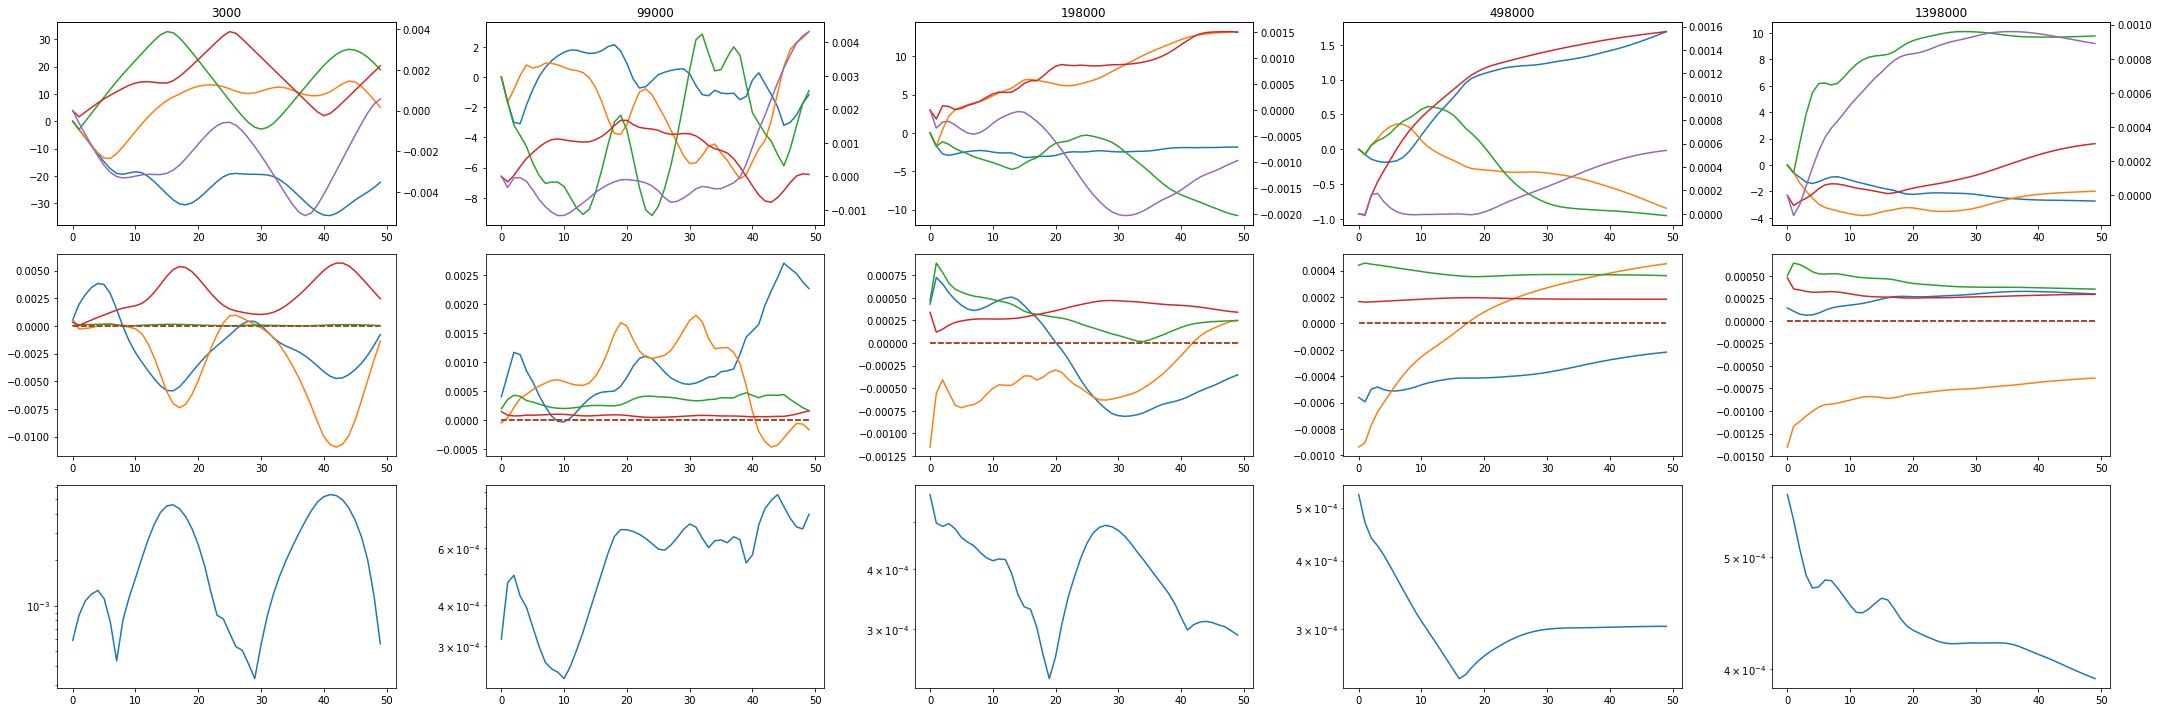

In [15]:
n = len(models)
plt.figure(figsize=(n*6,10))
for i, step in enumerate(models.keys()):
    model = models[step]
    env = model.env
    env.training = False

    history = []
    maes = []

    done = False
    observation = env.reset()[0]
    history.append(env.get_original_obs())
    while not done:
        action, _ = model.predict(observation, deterministic=True)
        observation, _, done, info = env.step(action)
        history.append(env.get_original_obs())
        maes.append(info[0]["mae"])

    history = np.array(history).squeeze()[:-1]
    actuators = history[:,-1,:5]
    desireds = history[:,-1,5:9]
    achieveds = history[:,-1,9:13]
    
    plt.subplot(3, n, i+1)
    plt.title(step)
    plt.plot(actuators[:,0])
    plt.plot(actuators[:,1])
    plt.plot(actuators[:,2])
    ax1 = plt.twinx()
    ax1.plot([])
    ax1.plot([])
    ax1.plot([])
    ax1.plot(actuators[:,3])
    ax1.plot(actuators[:,4])

    plt.subplot(3, n, n+i+1)
    plt.plot(achieveds[:,0], c="tab:blue")
    plt.plot(desireds[:,0], c="tab:blue", ls="--")
    plt.plot(achieveds[:,1], c="tab:orange")
    plt.plot(desireds[:,1], c="tab:orange", ls="--")
    plt.plot(achieveds[:,2], c="tab:green")
    plt.plot(desireds[:,2], c="tab:green", ls="--")
    plt.plot(achieveds[:,3], c="tab:red")
    plt.plot(desireds[:,3], c="tab:red", ls="--")

    plt.subplot(3, n, 2*n+i+1)
    plt.yscale("log")
    plt.plot(maes)

plt.tight_layout()
plt.show()

## giddy-fire-124
Turn off all generalisation (same misalignments, same incoming, same desired) with gamma 0.99, otherwise like baseline

In [3]:
def make_env():
    env = ARESEASequential(
        backend="simulation",
        backendargs={"measure_beam": "direct"}
    )
    env = ResetActuators(env)
    env = TimeLimit(env, max_episode_steps=50)
    env = RescaleAction(env, -1, 1)
    return env


def load(log_path, step):
    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_path}/vec_normalize_{step}_steps.pkl", env)

    model = TD3.load(f"{log_path}/rl_model_{step}_steps.zip", env=env, device="cpu")

    return model

In [6]:
log_path = "log/giddy-fire-124"
eval_times = [3000, 132000, 292000, 1000000, 2000000, 3000000]
fixed_eval_times = [round_to_multiple(t, 3000) for t in eval_times]
print(f"{fixed_eval_times = }")
models = {step: load(log_path,step) for step in fixed_eval_times}

fixed_eval_times = [3000, 132000, 291000, 999000, 1998000, 3000000]


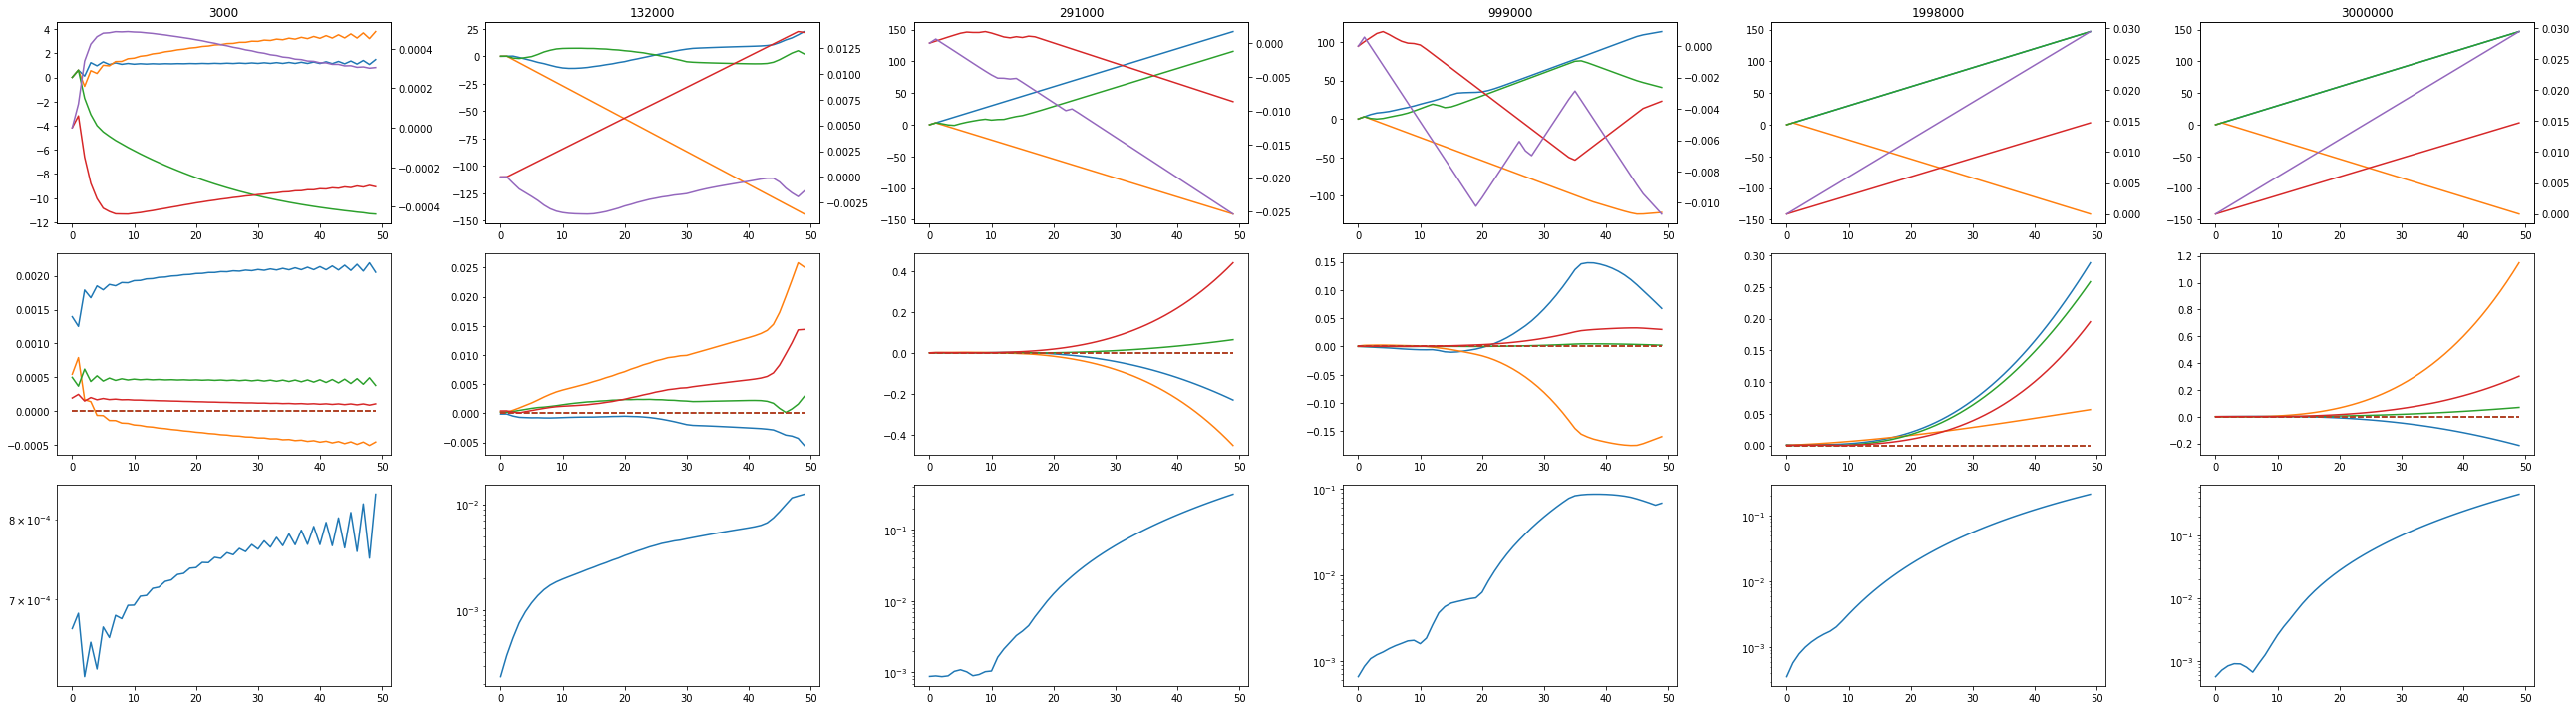

In [7]:
n = len(models)
plt.figure(figsize=(n*6,10))
for i, step in enumerate(models.keys()):
    model = models[step]
    env = model.env
    env.training = False

    history = []
    maes = []

    done = False
    observation = env.reset()[0]
    history.append(env.get_original_obs())
    while not done:
        action, _ = model.predict(observation, deterministic=True)
        observation, _, done, info = env.step(action)
        history.append(env.get_original_obs())
        maes.append(info[0]["mae"])

    history = np.array(history).squeeze()[:-1]
    actuators = history[:,:5]
    desireds = history[:,5:9]
    achieveds = history[:,9:13]
    
    plt.subplot(3, n, i+1)
    plt.title(step)
    plt.plot(actuators[:,0])
    plt.plot(actuators[:,1])
    plt.plot(actuators[:,2])
    ax1 = plt.twinx()
    ax1.plot([])
    ax1.plot([])
    ax1.plot([])
    ax1.plot(actuators[:,3])
    ax1.plot(actuators[:,4])

    plt.subplot(3, n, n+i+1)
    plt.plot(achieveds[:,0], c="tab:blue")
    plt.plot(desireds[:,0], c="tab:blue", ls="--")
    plt.plot(achieveds[:,1], c="tab:orange")
    plt.plot(desireds[:,1], c="tab:orange", ls="--")
    plt.plot(achieveds[:,2], c="tab:green")
    plt.plot(desireds[:,2], c="tab:green", ls="--")
    plt.plot(achieveds[:,3], c="tab:red")
    plt.plot(desireds[:,3], c="tab:red", ls="--")

    plt.subplot(3, n, 2*n+i+1)
    plt.yscale("log")
    plt.plot(maes)

plt.tight_layout()
plt.show()

## amber-leaf-125
Baseline but with misalignments and incoming beam added to observation (making temporal integration unnecessary)

In [1]:
def make_env():
    env = ARESEASequential(
        backend="simulation",
        backendargs={"measure_beam": "direct"}
    )
    env = ResetActuators(env)
    env = TimeLimit(env, max_episode_steps=50)
    env = RescaleAction(env, -1, 1)
    return env


def load(log_path, step):
    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_path}/vec_normalize_{step}_steps.pkl", env)

    model = TD3.load(f"{log_path}/rl_model_{step}_steps.zip", env=env, device="cpu")

    return model

In [5]:
log_path = "log/amber-leaf-125"
eval_times = [3000, 36000, 132000, 500000, 1000000, 3000000]
fixed_eval_times = [round_to_multiple(t, 3000) for t in eval_times]
print(f"{fixed_eval_times = }")
models = {step: load(log_path,step) for step in fixed_eval_times}

fixed_eval_times = [3000, 36000, 132000, 498000, 999000, 3000000]


ValueError: Observation spaces do not match: Box([-3.e+01 -3.e+01 -3.e+01 -3.e-03 -6.e-03 -2.e-03 -2.e-03  0.e+00  0.e+00
    -inf    -inf  0.e+00  0.e+00 -4.e-04 -4.e-04 -4.e-04 -4.e-04 -4.e-04
 -4.e-04 -4.e-04 -4.e-04 -1.e-03 -1.e-03 -1.e-04 -1.e-04  1.e-05  1.e-05
  1.e-06  1.e-06  1.e-06  1.e-04  8.e+07], [3.0e+01 3.0e+01 3.0e+01 3.0e-03 6.0e-03 2.0e-03 2.0e-03 5.0e-04 5.0e-04
     inf     inf     inf     inf 4.0e-04 4.0e-04 4.0e-04 4.0e-04 4.0e-04
 4.0e-04 4.0e-04 4.0e-04 1.0e-03 1.0e-03 1.0e-04 1.0e-04 5.0e-04 5.0e-04
 5.0e-05 5.0e-05 5.0e-05 1.0e-03 1.6e+08], (32,), float32) != Box([-3.e+01 -3.e+01 -3.e+01 -3.e-03 -6.e-03 -2.e-03 -2.e-03  0.e+00  0.e+00
    -inf    -inf  0.e+00  0.e+00], [3.e+01 3.e+01 3.e+01 3.e-03 6.e-03 2.e-03 2.e-03 5.e-04 5.e-04    inf
    inf    inf    inf], (13,), float32)

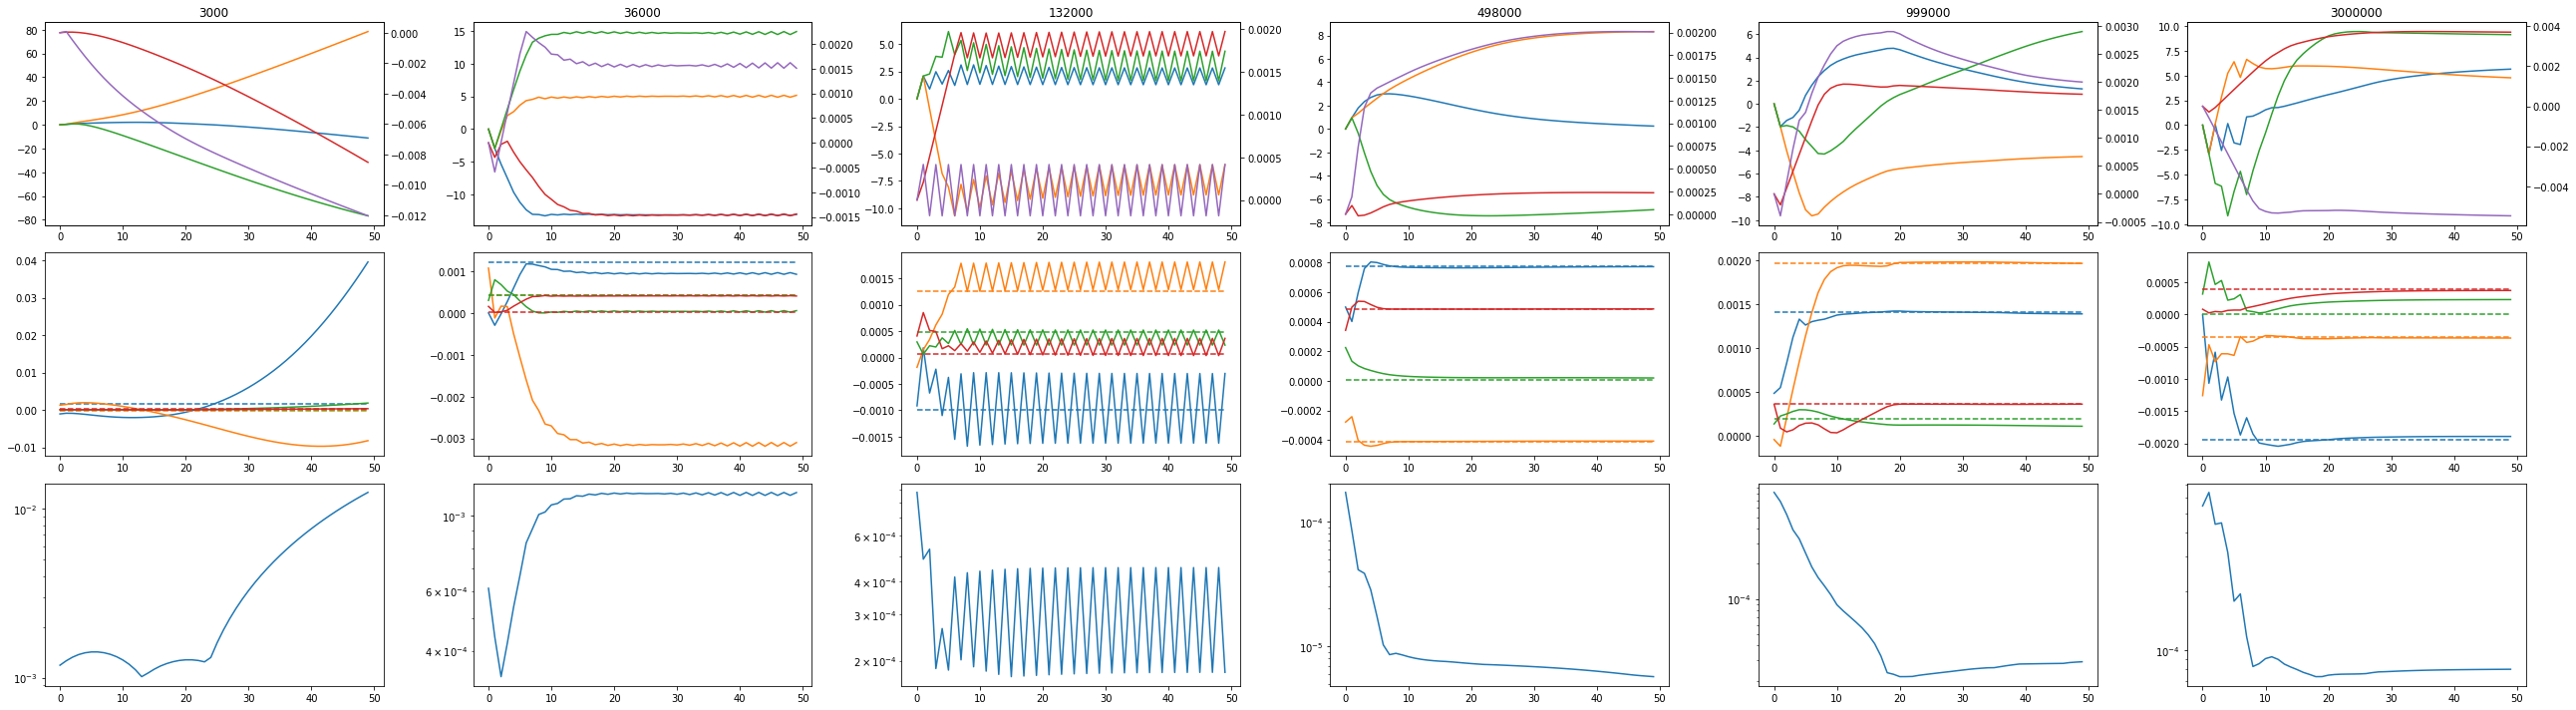

In [42]:
n = len(models)
plt.figure(figsize=(n*6,10))
for i, step in enumerate(models.keys()):
    model = models[step]
    env = model.env
    env.training = False

    history = []
    maes = []

    done = False
    observation = env.reset()[0]
    history.append(env.get_original_obs())
    while not done:
        action, _ = model.predict(observation, deterministic=True)
        observation, _, done, info = env.step(action)
        history.append(env.get_original_obs())
        maes.append(info[0]["mae"])

    history = np.array(history).squeeze()[:-1]
    actuators = history[:,:5]
    desireds = history[:,5:9]
    achieveds = history[:,9:13]
    
    plt.subplot(3, n, i+1)
    plt.title(step)
    plt.plot(actuators[:,0])
    plt.plot(actuators[:,1])
    plt.plot(actuators[:,2])
    ax1 = plt.twinx()
    ax1.plot([])
    ax1.plot([])
    ax1.plot([])
    ax1.plot(actuators[:,3])
    ax1.plot(actuators[:,4])

    plt.subplot(3, n, n+i+1)
    plt.plot(achieveds[:,0], c="tab:blue")
    plt.plot(desireds[:,0], c="tab:blue", ls="--")
    plt.plot(achieveds[:,1], c="tab:orange")
    plt.plot(desireds[:,1], c="tab:orange", ls="--")
    plt.plot(achieveds[:,2], c="tab:green")
    plt.plot(desireds[:,2], c="tab:green", ls="--")
    plt.plot(achieveds[:,3], c="tab:red")
    plt.plot(desireds[:,3], c="tab:red", ls="--")

    plt.subplot(3, n, 2*n+i+1)
    plt.yscale("log")
    plt.plot(maes)

plt.tight_layout()
plt.show()